In [634]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import numpy as np

### Data preprocessing

Loading datasets

In [635]:
white_df = pd.read_csv('wine_white.csv')
red_df = pd.read_csv('wine_red.csv')

Joining dataframes

In [636]:
joined_df = pd.concat([white_df, red_df], ignore_index=True)
print(f'Dataset size: {joined_df.shape[0]} with {joined_df.shape[1] - 1} features (1 to be predicted)')

Dataset size: 6497 with 12 features (1 to be predicted)


datatypes

- 11 numerical
- 2 categorical

In [637]:
print(joined_df.dtypes)

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
wine_type                object
target                   object
dtype: object


let's check categorical values

In [638]:
print(f'Categories count:\n{joined_df[['wine_type', 'target']].nunique()}\n')
print(f'Wine types:\n{joined_df['wine_type'].dropna().unique()}\n')
print(f'Target types:\n{joined_df['target'].dropna().unique()}\n')

Categories count:
wine_type    2
target       5
dtype: int64

Wine types:
['white' 'red']

Target types:
['B' 'C' 'A' 'D' '9']



We can cast ``wine_type`` to ``is_red``


In [639]:
joined_df['wine_type'] = joined_df['wine_type'].apply(lambda x: 1 if x == 'red' else 0 if x else None)
joined_df.rename(columns={'wine_type': 'is_red'}, inplace=True)

With ``target`` we need to understand what ``9`` means

``A`` to ``D`` ordinal is obvious (from best to worst)

In [640]:
joined_df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,is_red
count,6497.000000,6183.000000,6497.000000,6497.000000,6497.000000,6171.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339992,0.318633,5.443235,0.056034,30.521958,115.744574,0.994697,3.218501,0.531268,10.491801,0.232415
std,1.296434,0.165178,0.145318,4.757804,0.035034,17.766855,56.521855,0.002999,0.160787,0.148806,1.192712,0.422405
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,0.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,0.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,0.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,0.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,1.000000


In [641]:
joined_df[joined_df['target'] == '9']

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,is_red,target
774,9.1,0.27,0.45,10.6,0.035,28.0,124.0,0.99700,3.20,0.46,10.4,0,9
820,6.6,0.36,0.29,1.6,0.021,24.0,85.0,0.98965,3.41,0.61,12.4,0,9
827,7.4,0.24,0.36,2.0,0.031,27.0,139.0,0.99055,3.28,0.48,12.5,0,9
876,6.9,0.36,0.34,4.2,0.018,57.0,119.0,0.98980,3.28,0.36,12.7,0,9
1605,7.1,0.26,0.49,2.2,0.032,31.0,113.0,0.99030,3.37,0.42,12.9,0,9


Can't see any anomalies with '9',

but as we can't define those values (it's target feature, and imputing it will cause bias)

we gonna drop those rows

In [642]:
joined_df = joined_df[joined_df['target'] != '9']

Now we can translate target to ordinal ints

In [643]:
joined_df['target'] = joined_df['target'].apply(lambda x: {'A': 3, 'B': 2, 'C': 1, 'D': 0}[x])

Data missing values check

In [644]:
print(joined_df.isna().sum())

fixed acidity             0
volatile acidity        314
citric acid               0
residual sugar            0
chlorides                 0
free sulfur dioxide     326
total sulfur dioxide      0
density                   0
pH                        0
sulphates                 0
alcohol                   0
is_red                    0
target                    0
dtype: int64


We have 3 columns with missing values, let's check if we should drop those columns, and if not let's fill those NaN using

Let's say a ``threshold`` is 0.7 and if column or row contains less data than ``threshold`` we will drop it

N.B. as we have 12 + 1 features and only 3 columns with missing values =>

in worst case scenario when row would contain all 3 missing values (12-3)/12 is bigger than ``threshold`` =>

no rows check

same with columns max column NaN count is 331. (6497-331)/6497 is bigger than ``threshold`` =>

no column check

In [645]:
joined_df.columns[joined_df.isna().sum().to_numpy().nonzero()]

Index(['volatile acidity', 'free sulfur dioxide'], dtype='object')

### Outliers

So, let's look through outliers

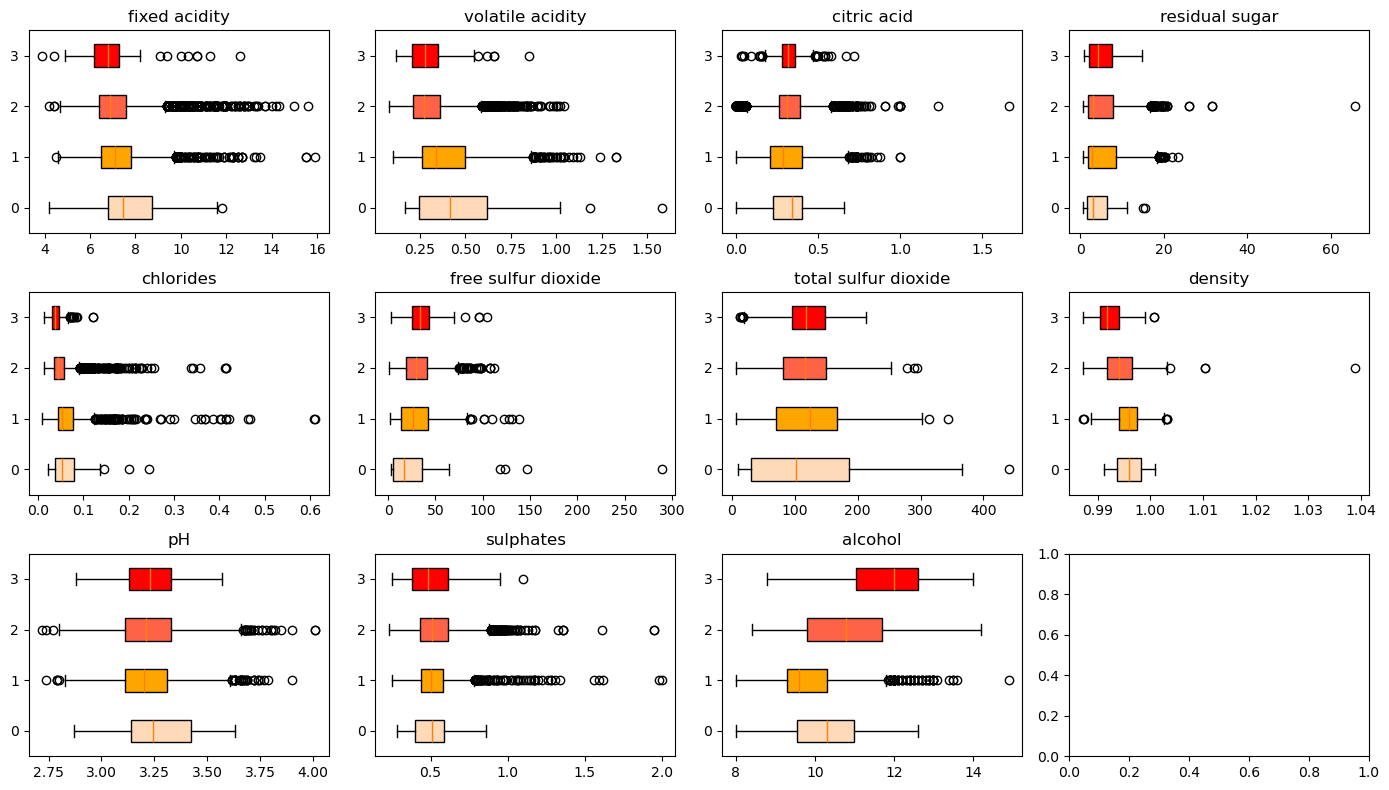

In [646]:
fig, ax = plt.subplots(3, 4, figsize=(14, 8))
for i in range(3):
    for j in range(4):
        col = joined_df.columns[i * 4 + j]
        if col == 'is_red':
            continue

        labels = sorted(joined_df['target'].unique().tolist())
        colors = ['peachpuff', 'orange', 'tomato', 'red']

        data = joined_df.dropna().groupby('target')[col].apply(list)

        bplot = ax[i][j].boxplot(data, vert=False, patch_artist=True, tick_labels=labels, showfliers=True)

        for patch, color in zip(bplot['boxes'], colors):
            patch.set_facecolor(color)

        ax[i][j].set_title(col)
fig.tight_layout()
plt.show()

Let's get rid of outliers (column by column)

In [647]:
def drop_iqr_outliers(df, cols=None, iqr_mult=1.5, keep_na=True):
    if cols is None:
        cols = df.select_dtypes(include="number").columns

    # Compute bounds once on the full data
    q1 = df[cols].quantile(0.25)
    q3 = df[cols].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - iqr_mult * iqr
    upper = q3 + iqr_mult * iqr

    # Build per-column in-range masks
    in_range = df[cols].ge(lower) & df[cols].le(upper)
    if keep_na:
        in_range = in_range | df[cols].isna()

    # Keep only rows that are in-range for ALL selected columns
    keep_mask = in_range.all(axis=1)
    return df[keep_mask].copy()

# Example: exclude last two columns if they shouldn’t be checked
cols_to_check = joined_df.columns[:-2]
joined_df = drop_iqr_outliers(joined_df, cols=cols_to_check)

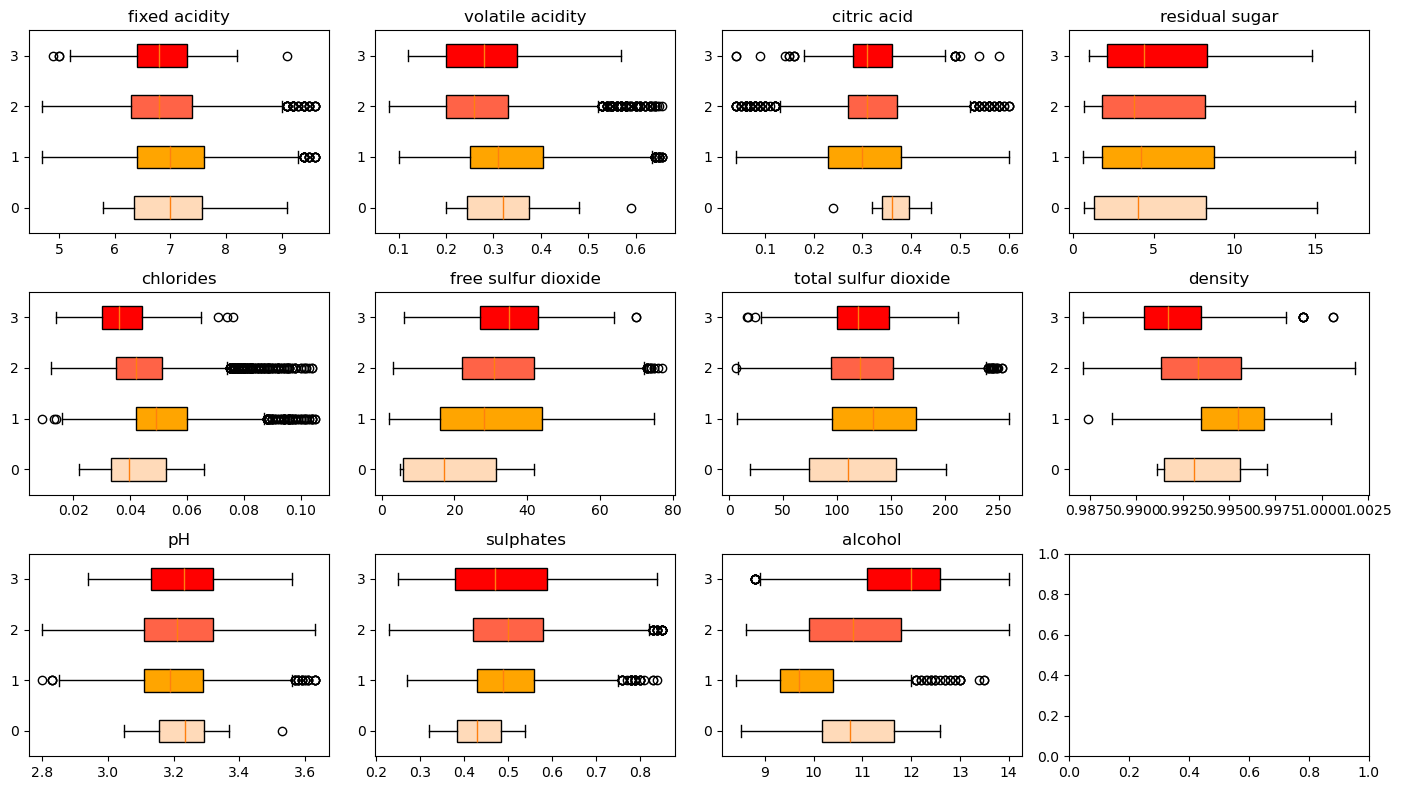

In [648]:
fig, ax = plt.subplots(3, 4, figsize=(14, 8))
for i in range(3):
    for j in range(4):
        col = joined_df.columns[i * 4 + j]
        if col == 'is_red':
            continue

        labels = sorted(joined_df['target'].unique().tolist())
        colors = ['peachpuff', 'orange', 'tomato', 'red']

        data = joined_df.dropna().groupby('target')[col].apply(list)

        bplot = ax[i][j].boxplot(data, vert=False, patch_artist=True, tick_labels=labels, showfliers=True)

        for patch, color in zip(bplot['boxes'], colors):
            patch.set_facecolor(color)

        ax[i][j].set_title(col)
fig.tight_layout()
plt.show()

First and last 5 items in dataset

In [649]:
pd.concat([joined_df.head(5), joined_df.tail(5)])

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,is_red,target
1,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,0,2
2,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,0,2
3,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,0,2
4,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,0,2
5,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,0,2
6492,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,1,1
6493,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,1,2
6494,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,1,2
6495,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,1,1
6496,6.0,0.310,0.47,3.6,0.067,18.0,42.0,0.99549,3.39,0.66,11.0,1,2


### Visualisations

``target`` counts

target
2    3189
1    1656
3     169
0      11
Name: count, dtype: int64


<BarContainer object of 4 artists>

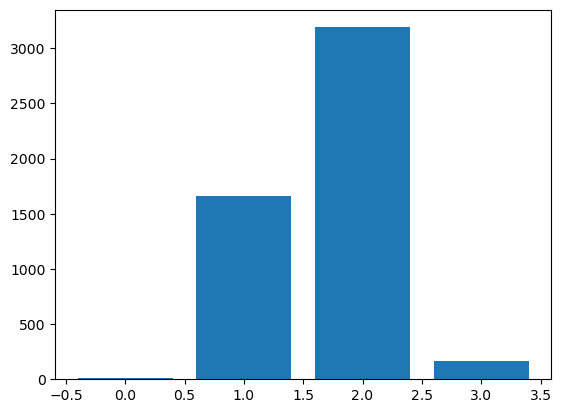

In [650]:
target_counts = joined_df['target'].value_counts()
print(target_counts)
plt.bar(target_counts.keys(), target_counts)

Histograms of features

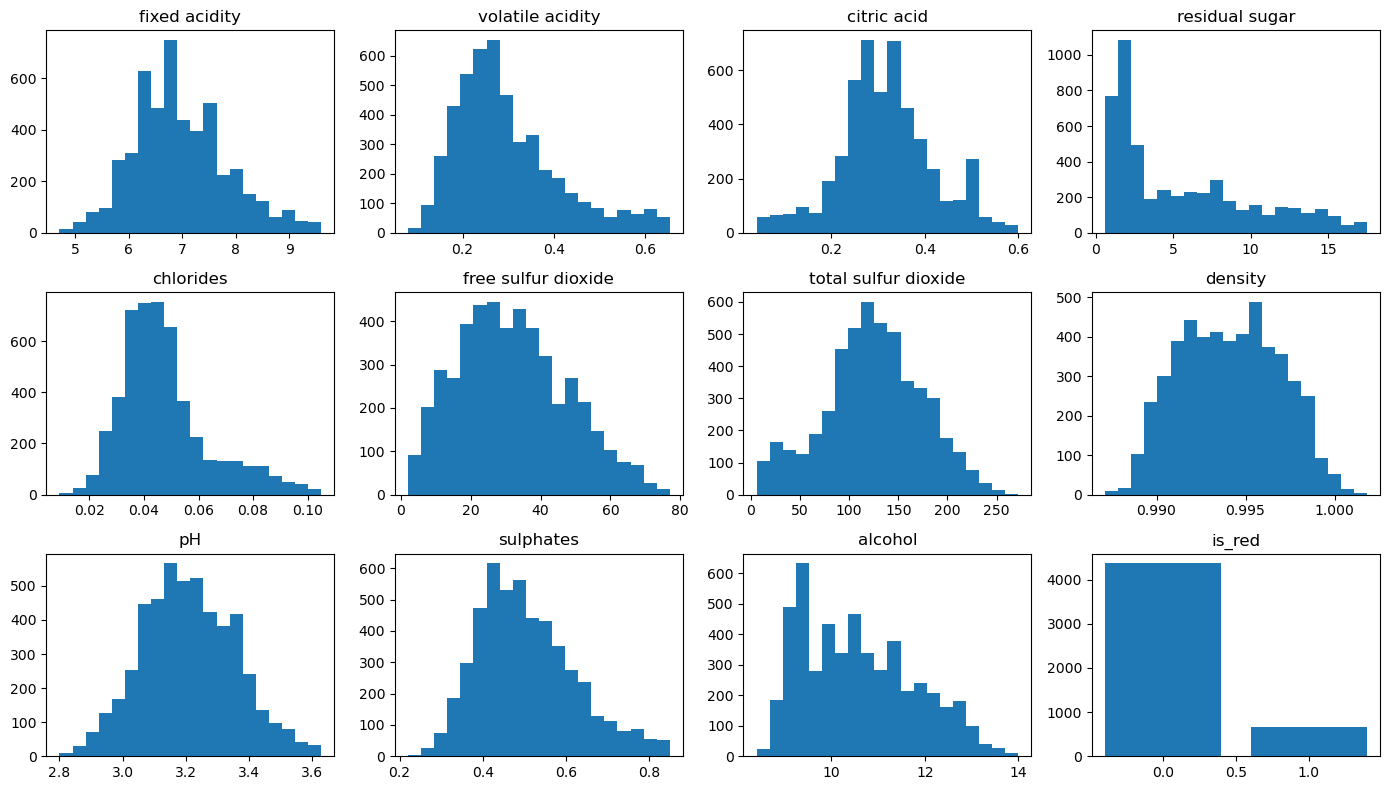

In [651]:
fig, ax = plt.subplots(3, 4, figsize=(14, 8))
for i in range(3):
    for j in range(4):
        col = joined_df.columns[i * 4 + j]
        if col == 'is_red':
            continue
        ax[i][j].hist(joined_df[col].dropna(), bins=20)
        ax[i][j].set_title(col)
wine_type_counts = joined_df['is_red'].value_counts()
ax[2][3].bar(wine_type_counts.keys(), wine_type_counts)
ax[2][3].set_title('is_red')
fig.tight_layout()
plt.show()

### Scatter plot

first let's do correlation test with ``target``

for that we will do wine type encoding and transform ``target`` to ordinal int

In [652]:
joined_df.corr().iloc[-1:,:]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,is_red,target
target,-0.101841,-0.22804,0.066751,-0.023829,-0.250175,0.059879,-0.074383,-0.281623,0.024514,0.02716,0.393002,-0.107139,1.0


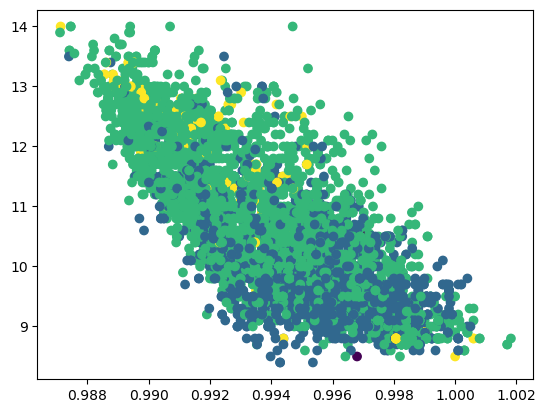

In [653]:
plt.scatter(joined_df['density'], joined_df['alcohol'], c=joined_df['target'])

In [654]:
import seaborn as sns

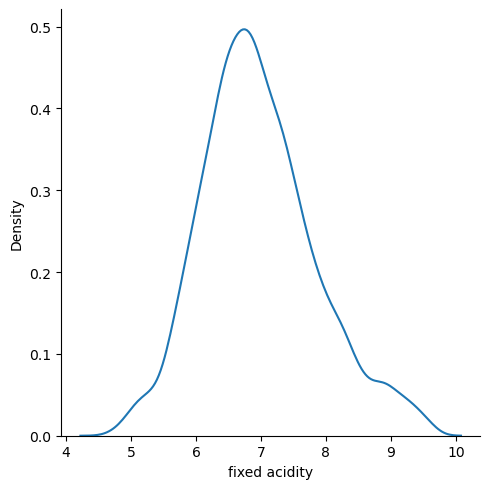

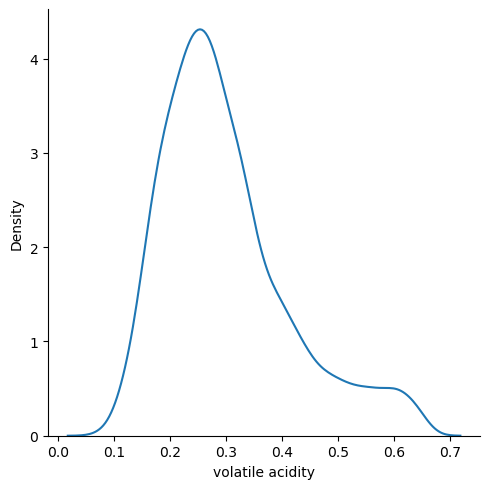

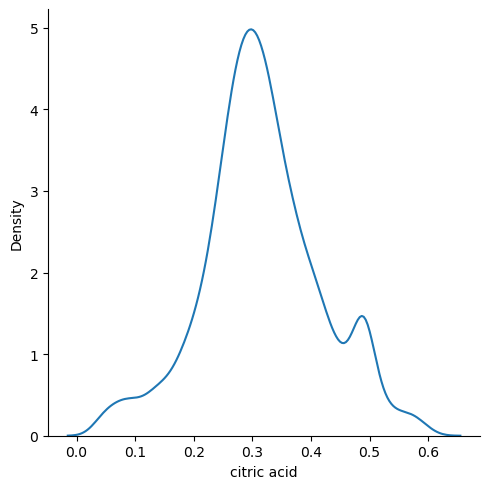

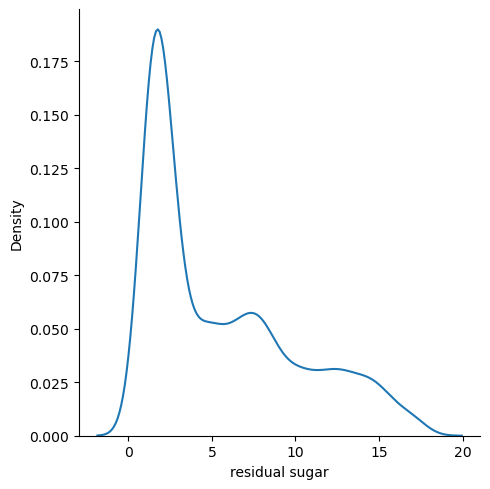

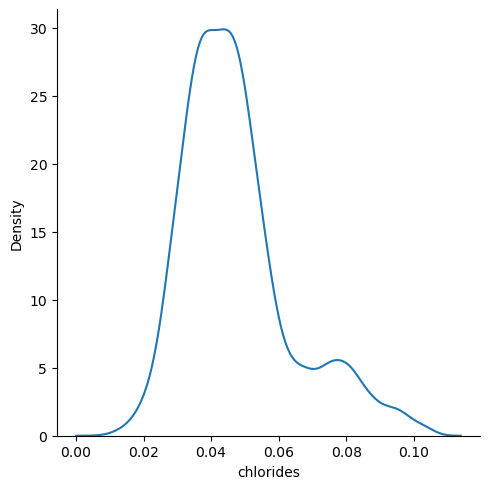

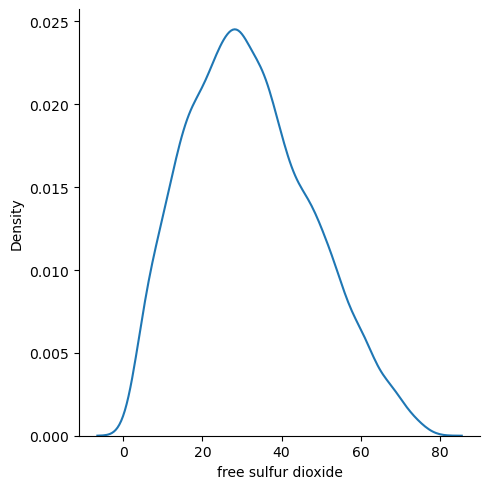

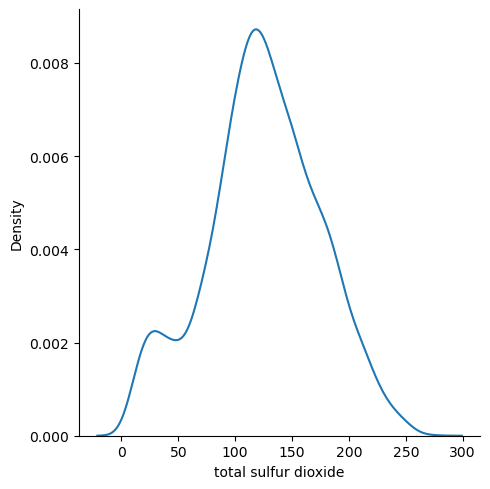

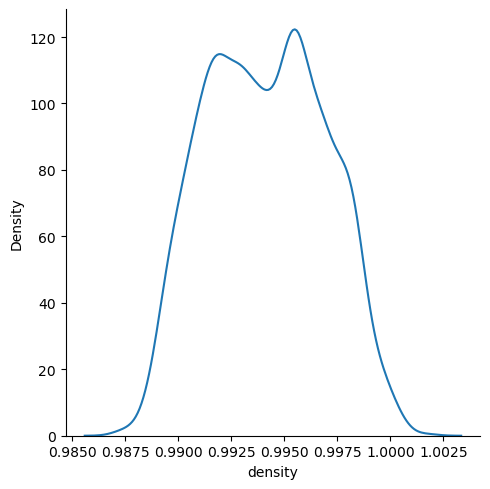

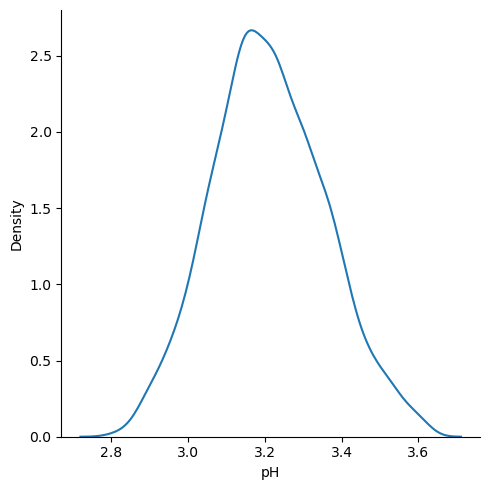

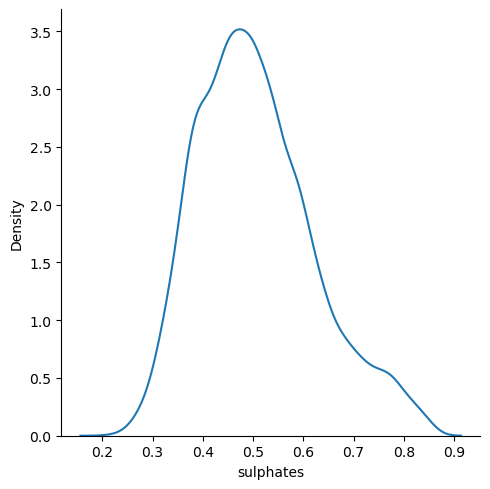

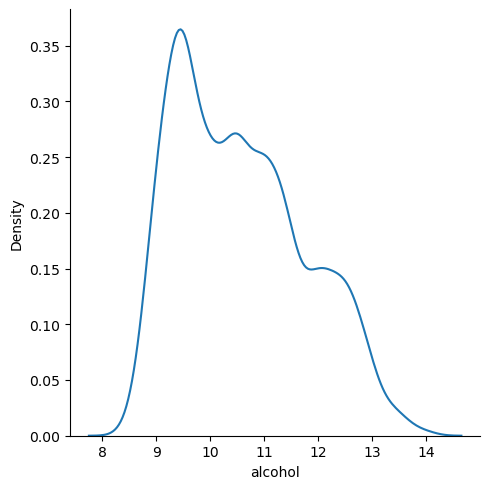

In [658]:
for i in range(3):
    for j in range(4):
        col = joined_df.columns[i * 4 + j]
        if col == 'is_red':
            continue

        sns.displot(joined_df[col], kind="kde")